# checking out model

In [1]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [12]:
basepath = "/sciclone/geograd/stmorse/reddit/subreddit/science"

In [ ]:
# load graphs 
with open(os.path.join(basepath, "filtered/graph_2008_union.json")) as f:
    graph = json.load(f)

# Add nodes from graph['user_to_idx'] in order of their indices
G = nx.Graph()
for user, idx in sorted(graph['user_to_idx'].items(), key=lambda x: x[1]):
    G.add_node(idx, user=user)

# Convert the edge index lists into edge tuples and add edges
edges = list(zip(graph['edge_index'][0], graph['edge_index'][1]))
G.add_edges_from(edges)

print(f"G: nodes {G.number_of_nodes()} edges {G.number_of_edges()}")

# Get the largest connected component
# Filter edges based on the weight threshold
threshold = 10
edges_to_keep = [(u, v, w) for u, v, w in zip(graph['edge_index'][0], graph['edge_index'][1], graph['edge_weight']) if w >= threshold]

# Create a new graph with filtered edges and store edge weights
G = nx.Graph()
for u, v, w in edges_to_keep:
    G.add_edge(u, v, weight=w)
print(f"G: nodes {G.number_of_nodes()} edges {G.number_of_edges()}")

largest_cc = max(nx.connected_components(G), key=len)
H = G.subgraph(largest_cc)
print(f"H: nodes {H.number_of_nodes()} edges {H.number_of_edges()}")

G: nodes 116709 edges 116097
G: nodes 389 edges 348
H: nodes 216 edges 250


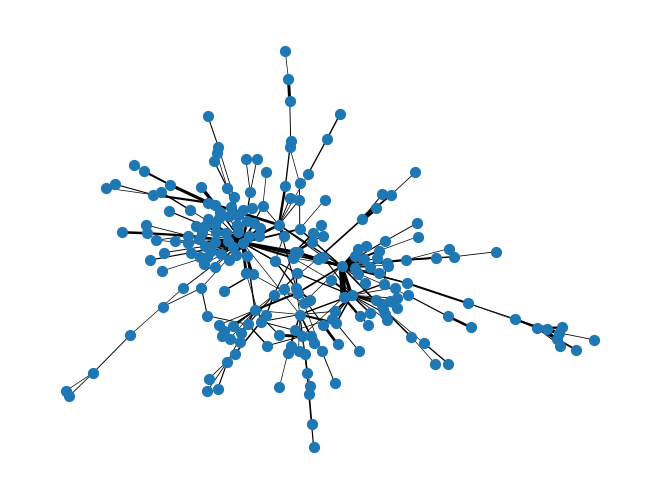

In [10]:
# Generate positions for all nodes using a layout algorithm
pos = nx.spring_layout(H, seed=42)

# Extract weights from each edge in the component
weights = [H[u][v]['weight'] for u, v in H.edges()]

# Optionally, scale edge widths (this scales weights between 0.5 and 5)
min_w, max_w = min(weights), max(weights)
scale = 10 / (max_w - min_w) if max_w != min_w else 1
edge_widths = [(w - min_w) * scale + 0.5 for w in weights]

# Draw the graph with edge widths proportional to their weight
nx.draw(H, pos, with_labels=False, node_size=50, width=edge_widths)
plt.show()

In [14]:
feat0 = np.load(os.path.join(basepath, "filtered/features_2007_union.npy"))
feat1 = np.load(os.path.join(basepath, "filtered/features_2008_union.npy"))
feat0.shape, feat1.shape

((116709, 15), (116709, 15))

In [16]:
# Extract unique nodes from edges_to_keep
indices = list(set([u for u, v in H.edges()] + [v for u, v in H.edges()]))
indices = np.array(indices)

feat0_trim = feat0[indices,:]
feat1_trim = feat1[indices,:]
feat0_trim.shape, feat1_trim.shape

((216, 15), (216, 15))

In [17]:
cfeat = np.vstack((feat0_trim, feat1_trim))
cfeat_t = TSNE(n_components=2).fit_transform(cfeat)

Check: 208 <? 216


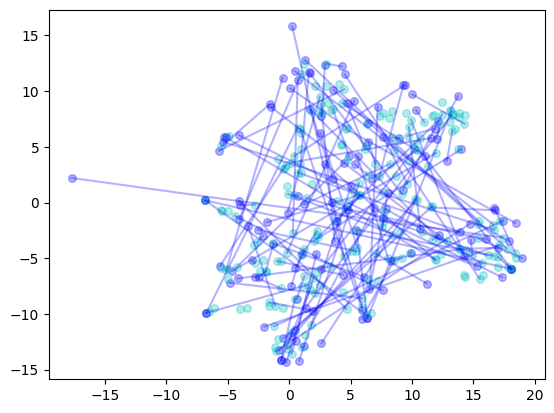

In [26]:
n = 216

zidx = np.where(np.sum(cfeat, axis=1) == 0)[0]
print(f'Check: {max(zidx)} <? 216')

for i in range(n):
    # skip entries in t0 that are carryover from t1
    if i in zidx:
        continue

    plt.plot(cfeat_t[[i, i+n],0], cfeat_t[[i, i+n],1], 'b-', alpha=0.3)

cfeat_t0_t = cfeat_t[:n,:][cfeat_t[:n,0] > -20]
plt.scatter(cfeat_t0_t[:,0], cfeat_t0_t[:,1], s=30, c='b', alpha=0.3)
plt.scatter(cfeat_t[n:,0], cfeat_t[n:,1], s=30, c='c', alpha=0.3)

In [23]:
ioi = np.where(cfeat_t[:,0] < -20)[0]
print(len(ioi))
print(cfeat[ioi[5:15],:])

84
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


# Feature trajectory baseline testing

In [1]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
basepath = '/sciclone/geograd/stmorse/reddit/subreddit/science'

In [8]:
def train_multi_step_linear(feats_by_year, years, alpha=0.0):
    """
    feats_by_year: dict mapping year -> np.ndarray shape (n, d)
    years: sorted list of years to use for training (will use t -> t+1 for t in years[:-1])
    alpha: ridge regularization; 0 => ordinary least squares
    Returns: fitted model, train_mse
    """
    # collect training pairs
    Xs, Ys = [], []
    for t in years[:-1]:
        Xs.append(feats_by_year[t])
        Ys.append(feats_by_year[t+1])
    X = np.vstack(Xs)   # shape (n*(T-1), d)
    Y = np.vstack(Ys)   # same shape

    # fit linear map
    if alpha > 0:
        model = Ridge(alpha=alpha)
    else:
        model = LinearRegression()
    model.fit(X, Y)

    # train MSE
    Y_pred = model.predict(X)
    mse = mean_squared_error(Y, Y_pred)
    print(f"Train MSE over all steps: {mse:.6f}")

    return model, mse

In [11]:
feats = { y: np.load(os.path.join(basepath, f"filtered/features_{y}_union.npy")) for y in range(2007, 2010+1) }
model, train_mse = train_multi_step_linear(feats, list(range(2007,2009+1)))

Train MSE over all steps: 0.037247


In [12]:
mean_squared_error(feats[2010], model.predict(feats[2009]))

0.043445284740937146

In [10]:
model.coef_.shape

(15, 15)

In [36]:
f0 = np.load(os.path.join(basepath, 'filtered/features_2008_union.npy'))
f1 = np.load(os.path.join(basepath, 'filtered/features_2009_union.npy'))
f0.shape, f1.shape

((2695, 15), (2695, 15))

This computes the baseline MSE of using f1 to predict f2

In [3]:
def filter_features(features_csv_1, features_csv_2, min_posts=10, random_state=42):
    np.random.seed(random_state)

    # Load CSVs
    df1 = pd.read_csv(features_csv_1)
    df2 = pd.read_csv(features_csv_2)
    print(f'Before filter, {len(df1)} and {len(df2)}')

    # Calculate total posts for each CSV
    df1['total_posts'] = df1.drop(columns=['author']).sum(axis=1)
    df2['total_posts'] = df2.drop(columns=['author']).sum(axis=1)

    # Filter authors with at least min_posts in both CSVs
    active_authors_1 = set(df1[df1['total_posts'] >= min_posts]['author'])
    active_authors_2 = set(df2[df2['total_posts'] >= min_posts]['author'])
    print(f'After filter, {len(active_authors_1)} and {len(active_authors_2)}')
    common_authors = active_authors_1 & active_authors_2
    print(f'After combining, {len(common_authors)}')

    # Filter both dataframes to include only common authors
    df1_filtered = df1[df1['author'].isin(common_authors)].sort_values(by='author')
    df2_filtered = df2[df2['author'].isin(common_authors)].sort_values(by='author')

    # Convert filtered dataframes to ndarray (excluding 'author' and 'total_posts' columns)
    arr1 = df1_filtered.drop(columns=['author', 'total_posts']).values
    arr2 = df2_filtered.drop(columns=['author', 'total_posts']).values

    # Perform L2-normalization row-wise
    arr1 = arr1 / np.linalg.norm(arr1, axis=1, keepdims=True)
    arr2 = arr2 / np.linalg.norm(arr2, axis=1, keepdims=True)
    print(f'Final shapes: {arr1.shape} and {arr2.shape}')

    return arr1, arr2

In [34]:
def linreg_baseline(f0, f1, train_ratio=0.7, val_ratio=0.15, random_state=42):
    """
    f0, f1: np.ndarrays of shape (n, k)
    Splits into train/val/test = train_ratio / val_ratio / (1-train_ratio-val_ratio),
    fits LinearRegression on (f0_train -> f1_train),
    prints & returns validation MSE.
    """
    # first split out test
    tv_ratio = train_ratio + val_ratio
    f0_trainval, f0_test, f1_trainval, f1_test = train_test_split(
        f0, f1, test_size=1 - tv_ratio, random_state=random_state
    )
    # then split train vs val
    val_size = val_ratio / tv_ratio
    f0_train, f0_val, f1_train, f1_val = train_test_split(
        f0_trainval, f1_trainval, test_size=val_size, random_state=random_state
    )

    # fit linear model
    model = LinearRegression()
    model.fit(f0_train, f1_train)

    # evaluate on val
    pred_val = model.predict(f0_val)
    val_mse = mean_squared_error(f1_val, pred_val)
    print(f"Validation MSE: {val_mse:.6f}")

    pred_val = model.predict(f0_test)
    test_mse = mean_squared_error(f1_test, pred_val)
    print(f"Test MSE: {test_mse:.6f}")

    return model, val_mse, {
        'train': (f0_train, f1_train),
        'val':   (f0_val,   f1_val),
        'test':  (f0_test,  f1_test)
    }

In [37]:
np.mean(np.linalg.norm(f0 - f1, axis=1)**2)

np.float64(0.9277062333561387)

In [38]:
model, mse_val, splits = linreg_baseline(f0, f1)

Validation MSE: 0.037029
Test MSE: 0.038342


In [5]:
f0_filtered, f1_filtered = filter_features(
    os.path.join(basepath, 'users/user_counts_2007.csv'),
    os.path.join(basepath, 'users/user_counts_2008.csv'),
    min_posts=10,
)

Before filter, 9071 and 21411
After filter, 1295 and 4845
After combining, 925
Final shapes: (925, 15) and (925, 15)


In [9]:
np.mean(np.linalg.norm(f0_filtered - f1_filtered, axis=1)**2)

np.float64(0.6019267189798638)

In [16]:
model, mse_val, splits = linreg_baseline(f0_filtered, f1_filtered)

Validation MSE: 0.023202
Test MSE: 0.023816


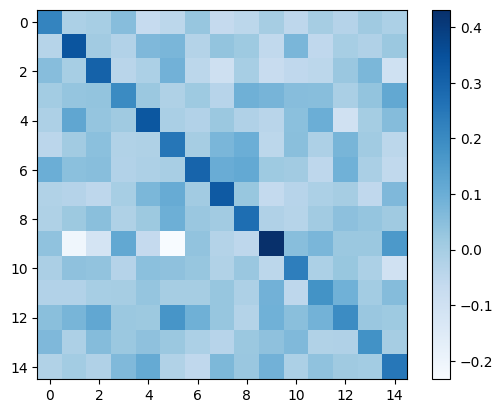

In [17]:
cb = plt.imshow(model.coef_, cmap='Blues')
plt.colorbar(cb)

In [14]:
z = np.vstack((f2007, f2008))
zp = PCA(n_components=2).fit_transform(z)
# zt = TSNE(n_components=2).fit_transform(zp)

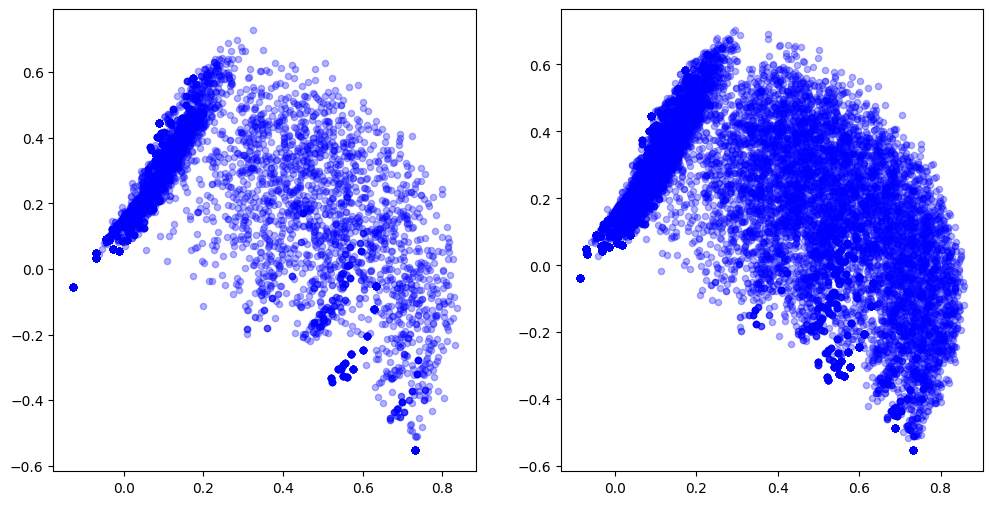

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))

axs[0].scatter(zp[:n,0], zp[:n,1], s=20, c='b', alpha=0.3)
axs[1].scatter(zp[n:,0], zp[n:,1], s=20, c='b', alpha=0.3)

In [16]:
with open("/sciclone/geograd/stmorse/reddit/subreddit/science/filtered/graph_2007_union.json") as f:
    graph = json.load(f)
graph.keys()

dict_keys(['user_to_idx', 'edge_index', 'edge_weight'])

In [19]:
# Add nodes from graph['user_to_idx'] in order of their indices
G = nx.Graph()
for user, idx in sorted(graph['user_to_idx'].items(), key=lambda x: x[1]):
    G.add_node(idx, user=user)

# Convert the edge index lists into edge tuples and add edges
edges = list(zip(graph['edge_index'][0], graph['edge_index'][1]))
G.add_edges_from(edges)

# Generate the adjacency matrix
A = nx.adjacency_matrix(G)
A.shape

(58826, 58826)

In [20]:
f0, f1 = f2007, f2008

deg = np.array(A.sum(1)).reshape(-1,1)
nbr_avg = A.dot(f0) / np.where(deg>0, deg, 1)
corr = np.corrcoef((f1 - f0).ravel(), nbr_avg.ravel())[0,1]
print("Δ vs neighbor‐avg correlation:", corr)

Δ vs neighbor‐avg correlation: -0.05753705787653392


In [3]:
with open("/sciclone/geograd/stmorse/reddit/subreddit/science/links/graph_2007-2007_filtered.json") as f:
    graph = json.load(f)
graph.keys()

dict_keys(['user_to_idx', 'edge_index', 'edge_weight'])

In [14]:
# Convert the edge index lists into edge tuples
edges = list(zip(graph['edge_index'][0], graph['edge_index'][1]))

# Create an undirected graph (change to nx.DiGraph() if needed)
G = nx.Graph()
G.add_edges_from(edges)

# Filter out nodes that have only one edge
# nodes_to_keep = [node for node, degree in G.degree() if degree > 1]
# H = G.subgraph(nodes_to_keep)

# Get the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
H = G.subgraph(largest_cc)

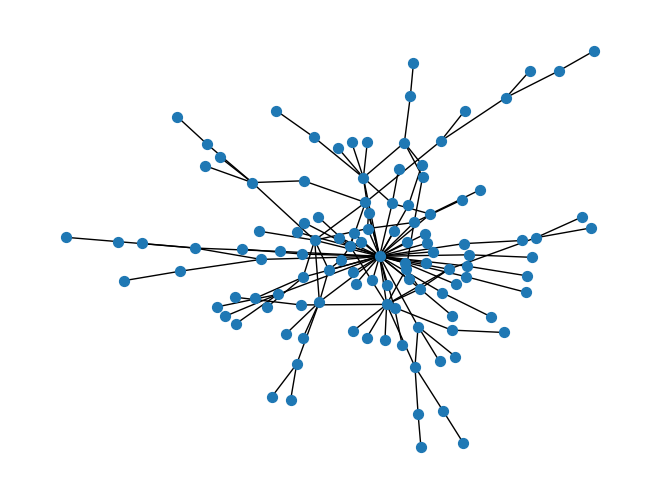

In [15]:
# Generate positions for all nodes using a layout algorithm
pos = nx.spring_layout(H, seed=42)

# Draw the graph with node labels and arrows
nx.draw(H, pos, with_labels=False, node_size=50)
plt.show()

In [16]:
# Convert the edge index lists and corresponding weights into a list of weighted edges
edges_with_weights = list(zip(graph['edge_index'][0],
                              graph['edge_index'][1],
                              graph['edge_weight']))

# Create an undirected weighted graph
G = nx.Graph()
for u, v, w in edges_with_weights:
    G.add_edge(u, v, weight=w)

# Get the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
H = G.subgraph(largest_cc)

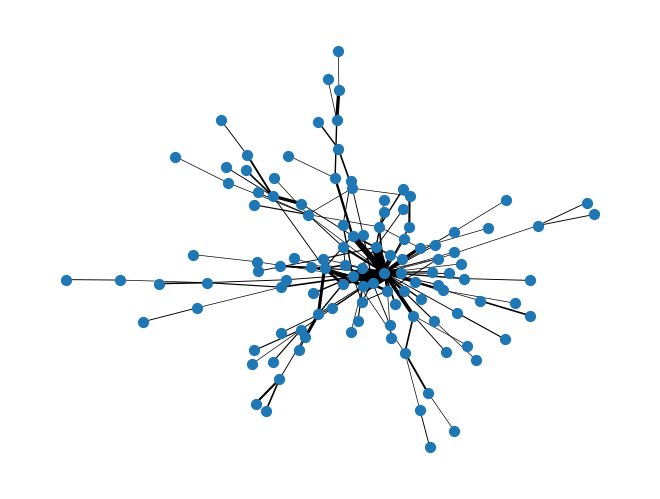

In [18]:
# Generate positions for the nodes using a layout algorithm
pos = nx.spring_layout(H, seed=42)

# Extract weights from each edge in the component
weights = [H[u][v]['weight'] for u, v in H.edges()]

# Optionally, scale edge widths (this scales weights between 0.5 and 5)
min_w, max_w = min(weights), max(weights)
scale = 10 / (max_w - min_w) if max_w != min_w else 1
edge_widths = [(w - min_w) * scale + 0.5 for w in weights]

# Draw the graph with edge widths proportional to their weight
nx.draw(H, pos, with_labels=False, node_size=50, width=edge_widths)
plt.show()

In [2]:
u0 = np.load("/sciclone/geograd/stmorse/reddit/subreddit/science/users/user_label_counts_2007_filtered.csv.npy")
u0.shape

(503, 15)

In [19]:
z = pd.read_csv("/sciclone/geograd/stmorse/reddit/subreddit/science/users/user_label_counts_2008.csv")
z.head()

,author,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-J-,0,0,1,0,1,1,4,0,0,5,2,2,1,0,0
1,02J,3,0,4,0,1,0,2,0,1,0,1,0,0,1,0
2,0_o,3,0,0,0,1,0,0,0,1,3,1,1,0,0,2
3,0gleth0rpe,1,0,0,1,0,2,2,0,0,3,0,0,3,0,0
4,0x44,0,0,0,1,1,0,0,0,0,2,3,0,2,1,0


In [20]:
z.shape

(2634, 16)

- "subreddit":"reddit.com",
- "score":3,
- "ups":3,
- "author_flair_css_class":null,
- "created_utc":1167609605,
- "body":"In the city I live in, I probably am.  Might even be the entire island.  Ah well.  It\'s one thing to know that somewhere, out there over the Internet, there are many like me.  It\'s another thing to know someone, in my everyday life off the internet, who is like me too.\\r\\n\\r\\nPixels on a screen just aren\'t enough.\\r\\n\\r\\nLife is a sadness.  But what else can we do but live it?  Life is a happiness.  But what else can we do but endure it?\\r\\n",
- "controversiality":0,
- "subreddit_id":"t5_6",
- "link_id":"t3_wiw8",
- "stickied":false,
- "gilded":0,
- "distinguished":null,
- "retrieved_on":1473809765,
- "author":"almkglor",
- "author_flair_text":null,
- "id":"cwl3r",
- "edited":false,
- "parent_id":"t1_cwjuc"

link_id is submission id
parent_id is t1_id for child comment, t3_id for top level comment

In [8]:
meta1 = pd.read_csv('/sciclone/geograd/stmorse/reddit/metadata/metadata_2007-01.csv', compression='gzip')
meta2 = pd.read_csv('/sciclone/geograd/stmorse/reddit/metadata/metadata_2007-02.csv', compression='gzip')
meta2.head()

,id,created_utc,parent_id,subreddit,subreddit_id,author,idx
0,c128oj,1170288047,t1_c124gv,programming,t5_2fwo,dons,0
1,c128ok,1170288055,t3_127fd,reddit.com,t5_6,indigoshift,1
2,c128ot,1170288082,t1_c128nr,reddit.com,t5_6,rutabaga,2
3,c128ov,1170288082,t1_c127e3,reddit.com,t5_6,dotrob,3
4,c128p3,1170288120,t3_121yo,programming,t5_2fwo,justinhj,4


In [10]:
meta1.query('id == "c128nr"')

,id,created_utc,parent_id,subreddit,subreddit_id,author,idx
58946,c128nr,1170287830,t3_127g7,reddit.com,t5_6,rutabaga,58946


In [13]:
with open('/sciclone/geograd/stmorse/reddit/links/graph.json', 'r') as f:
    z = json.load(f)

In [16]:
z['edge_index'][0][:5], z['edge_index'][1][:5], z['edge_weight'][:5]

([270, 2765, 2698, 2698, 1378],
 [2333, 3614, 2765, 3614, 2333],
 [1, 1, 1, 1, 1])

In [21]:
z2 = np.array(z['edge_weight'])
np.where(z2 > 10)

(array([  177,   212,   516,   637,   745,   775,   780,   947,  1004,
         1989,  2048,  2249,  2968,  2977,  3056,  3264,  3592,  4289,
         4608,  4743,  4799,  4877,  4902,  4965,  5021,  5025,  5638,
         5675,  6276,  6335,  6371,  6391,  7020,  7031,  8837,  9069,
         9081,  9082,  9670,  9677, 10657, 10847, 11264, 11385, 11991,
        12085, 12166, 12724, 13243, 13293, 13417, 13511, 13520, 13618,
        14299, 14616, 14690, 15297, 15417, 16004, 16387, 16416, 16435,
        16467, 17190, 17273, 18789, 18982, 19128, 19252, 19384, 20104,
        20160, 21472, 21566, 22185, 22443, 22543]),)

In [4]:
df = pd.read_csv('/sciclone/geograd/stmorse/reddit/subreddit/science/users/user_label_counts_2008.csv')
df.head()

,author,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-J-,0,0,1,0,1,1,4,0,0,5,2,2,1,0,0
1,02J,3,0,4,0,1,0,2,0,1,0,1,0,0,1,0
2,0_o,3,0,0,0,1,0,0,0,1,3,1,1,0,0,2
3,0gleth0rpe,1,0,0,1,0,2,2,0,0,3,0,0,3,0,0
4,0x44,0,0,0,1,1,0,0,0,0,2,3,0,2,1,0


In [6]:
t = df.drop(columns=['author']).values
l2_norms = np.sqrt(np.sum(t**2, axis=1, keepdims=True))
normalized_t = t / l2_norms
normalized_t[:5,:]

array([[0.        , 0.        , 0.13736056, 0.        , 0.13736056,
        0.13736056, 0.54944226, 0.        , 0.        , 0.68680282,
        0.27472113, 0.27472113, 0.13736056, 0.        , 0.        ],
       [0.52223297, 0.        , 0.69631062, 0.        , 0.17407766,
        0.        , 0.34815531, 0.        , 0.17407766, 0.        ,
        0.17407766, 0.        , 0.        , 0.17407766, 0.        ],
       [0.58834841, 0.        , 0.        , 0.        , 0.19611614,
        0.        , 0.        , 0.        , 0.19611614, 0.58834841,
        0.19611614, 0.19611614, 0.        , 0.        , 0.39223227],
       [0.18898224, 0.        , 0.        , 0.18898224, 0.        ,
        0.37796447, 0.37796447, 0.        , 0.        , 0.56694671,
        0.        , 0.        , 0.56694671, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.2236068 , 0.2236068 ,
        0.        , 0.        , 0.        , 0.        , 0.4472136 ,
        0.67082039, 0.        , 0.4472136 , 

In [8]:
tt = TSNE(n_components=2).fit_transform(normalized_t)

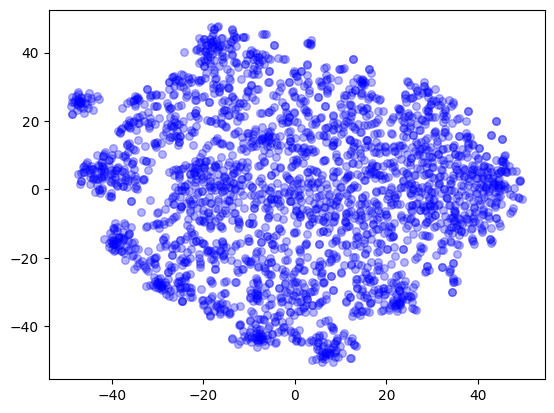

In [9]:
plt.scatter(tt[:,0], tt[:,1], s=30, c='b', alpha=0.3)

In [10]:
meta = pd.read_csv('/sciclone/geograd/stmorse/reddit/metadata/metadata_2007-01.csv', compression='gzip')
meta.head()

,id,created_utc,parent_id,subreddit,subreddit_id,author,idx
0,cwl3r,1167609605,t1_cwjuc,reddit.com,t5_6,almkglor,0
1,cwl3s,1167609743,t1_cwjys,reddit.com,t5_6,hitsman,1
2,cwl3t,1167609769,t3_wjui,reddit.com,t5_6,raldi,2
3,cwl3w,1167609826,t1_cwl34,reddit.com,t5_6,neoform,3
4,cwl3x,1167609856,t3_wl3v,reddit.com,t5_6,hotmama420,4


In [13]:
with open('/sciclone/geograd/stmorse/reddit/subreddit/science/links/graph_2007-2007.json') as f:
    graph = json.load(f)
graph.keys()

dict_keys(['user_to_idx', 'edge_index', 'edge_weight'])

In [14]:
graph['user_to_idx']

{'00u6166': 0,
 '0110110101101011': 1,
 '02J': 2,
 '09amw': 3,
 '0ntarget': 4,
 '0wnagetime': 5,
 '0x44': 6,
 '0xdefec8': 7,
 '1101010001': 8,
 '1239448837': 9,
 '12413515': 10,
 '1492': 11,
 '1812overture': 12,
 '1amgreat': 13,
 '238837426': 14,
 '24sparky': 15,
 '27182818284': 16,
 '2ndrateidiot': 17,
 '2pac2pac2': 18,
 '2stupid': 19,
 '300zedex': 20,
 '315was_an_inside_job': 21,
 '3n7r0py': 22,
 '42omle': 23,
 '4609287645': 24,
 '50evactab': 25,
 '54gy6dm': 26,
 '570': 27,
 '5P4C3M4N5P1FF': 28,
 '60secs': 29,
 '711was_a_retail_job': 30,
 '711was_an_inside_job': 31,
 '7oby': 32,
 '911WasntAnOutsideJob': 33,
 '911_was_a_job': 34,
 '911_was_an_inside_jo': 35,
 '9jack9': 36,
 '9ner': 37,
 'A-Pothead': 38,
 'ABeZero': 39,
 'ABentSpoon': 40,
 'AM088': 41,
 'AMerrickanGirl': 42,
 'AMessagetoURudy': 43,
 'ANRAND': 44,
 'ASmileInHisShoes': 45,
 'ATh90': 46,
 'AaronRowe': 47,
 'AbouBenAdhem': 48,
 'AdamAtlas': 49,
 'AdamPan': 50,
 'Admiral-Evident': 51,
 'AdmiralBumblebee': 52,
 'Adrewmc': 53